In [ ]:
# code to estimate the pressure from tangential wind component


In [150]:
import xarray as xr
import numpy as np
from math import radians
from datetime import datetime

import sys

from pyproj import Geod
geod = Geod(ellps='WGS84')

from scipy.interpolate import griddata
from scipy.optimize import curve_fit


sys.path.append('/home/amouche/PythonTool/atcf')
import atcf

import matplotlib.pyplot as plt


In [151]:
def loridan(r,X1,Y1,n,d,vmin,Rmax,Vmax):
    
    V=r*0
    Vinf = (Vmax-vmin)*((r)/Rmax)**n * np.exp((n-Rmax/X1)*(1-r/Rmax)) + vmin
    Vsup = Vmax**np.exp((-1)*((r-Rmax)/X1)*(r/Rmax)**Y1)
    V[r>Rmax] = Vsup[r>Rmax]
    V[r<=Rmax] = Vinf[r<=Rmax]
    return V


In [152]:
## Path

# SAR data (rotated)
sar_path = '/home/amouche/data/cyclobs/rotated_files/'

# TC Track
atcf_path = '/home/amouche/data/best-tracks-atcf-merge/'

In [153]:
# Listing with data filtered by Arthur. Center are from Leo. Rotated files from Robin
listing_file = 'listing_good_rotated_TCs.dat'
listing_path = '/home/amouche/data/cyclobs/'

# read listing
fid = open(listing_path+listing_file, "r")
sar_files = fid.readlines() 

# Test listing
#print(sar_files)
len(sar_files)

322

In [154]:
# A file to play with
#sar_files = sar_files[-2]
sar_files = sar_files[0:1]
sar_files = ['s1b-iw-owi-cm-20170923t104349-20170923t104554-000003-00D45F_ll_gd_rotated.nc ']

s1b-iw-owi-cm-20170923t104349-20170923t104554-000003-00D45F_ll_gd_rotated.nc
bal152017.dat


/home/amouche/miniconda3/envs/pyt3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in power
  """
/home/amouche/miniconda3/envs/pyt3/lib/python3.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


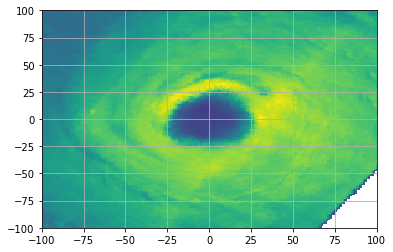

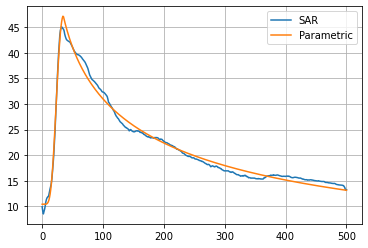

In [155]:
for sar_file in sar_files:
    
    sar_file = sar_file[:-1]

    # Read SAR netCDF file
    print(sar_file)
    sar_ds = xr.open_dataset(sar_path+sar_file)
    sar_time = datetime.strptime(str.split(sar_file,'-')[4], '%Y%m%dt%H%M%S')
    
    # Get / Read ATCF file
    print(atcf_file)
    atcf_file = sar_ds.attrs['Track source file']
    atcf_ds = atcf.read(atcf_path+atcf_file)
    
    # TC center from SAR
    lonc = float(sar_ds['lon_ref'])
    latc = float(sar_ds['lat_ref'])
    
    # Coriolis force
    Omega = 7.2921*pow(10,-5)
    f_coriolis = Omega*np.sin(radians(latc))
    
    # Air Density (for a pressure of 1 atm or 1013.25 hPa and Air Temperature of 20°C)
    rho = 1.2041 # Constant. Need for SST to refine
    
    # ==========================================    
    # Get ATCF variables colocated to SAR acquisition time
    # ==========================================
    
    # colocated time
    dat,arg = np.unique(atcf_ds['date'],return_index=True)
    udt = np.abs(atcf_ds['date'][arg]-sar_time)
    _idx = udt.index[np.argmin(udt)]
    _idxm = udt.index[np.argmin(udt)-1]
    _idxp = udt.index[np.argmin(udt)+1]
    # Pressure Pouter, Router, MSLP
    Pouter = atcf_ds['POUTER'][arg][_idx]
    Router = atcf_ds['ROUTER'][arg][_idx]*1609.34 # to be converted from n.mi to meter
    mslp = atcf_ds['MSLP'][arg][_idx]
    dp =  Pouter - mslp
    # Time difference
    dtimem = np.abs((atcf_ds['date'][arg][_idx]-atcf_ds['date'][arg][_idxm]).seconds) # with previous time step
    # Displacement
    az,bz,distm = geod.inv(atcf_ds['lon'][arg][_idx], atcf_ds['lat'][arg][_idx], atcf_ds['lon'][arg][_idxm], atcf_ds['lat'][arg][_idxm])
    #  Translation Speed (1 time step before)
    Vtransm = distm/dtimem
    # Dv/Dt and Dp/Dt

    # ==========================================        
    # Averaged and Parameterized SAR-derived tangential wind speed
    # ==========================================    
    
    # Loading data
    spd = np.array(sar_ds['wind_speed'])
    ws = np.abs(np.array(sar_ds['tangential_wind'])*spd)
    ra = np.array(sar_ds['r_polar'])
    th = np.mod(np.array(sar_ds['theta'])*180./np.pi,360)
    lon = np.array(sar_ds['lon_coords'])
    lat = np.array(sar_ds['lat_coords'])
    xx = np.array(sar_ds['x_coords'])
    yy = np.array(sar_ds['y_coords'])
    #-----------------------
    fig=plt.figure()
    plt.pcolormesh(xx,yy,spd)
    plt.axis([-100,100,-100,100]);plt.grid()
    #-----------------------
    # Polar grid for interpolation
    radius  = np.arange(501)+0.1
    #radius[0] = 0.1
    radius1 = radius*1.
    azimuth = np.arange(361)
    radius,azimuth = np.meshgrid(radius,azimuth)
    # Interpolation
    spd_ = griddata((ra.flatten(),th.flatten()),ws.flatten(),(radius,azimuth))#,method='nearest')
    xx_  = radius*np.cos(azimuth*np.pi/180.)
    yy_  = radius*np.sin(azimuth*np.pi/180.)
    # Averaged tangential wind speed
    spd_mean=np.nanmean(spd_,axis=0)
    #-----------------------
    fig=plt.figure()
    plt.plot(radius1,spd_mean,label='SAR')
    plt.grid()
    #-----------------------
    # Parameterized tangential wind speed
    filtre = (~np.isnan(spdm.ravel())) #& (radius1<50)
    XYin= radius1.ravel()[filtre]
    SPDm = spd_mean.ravel()[filtre]
    #
    Vmax=np.nanmax(SPDm); Rmax=XYin[np.nanargmax(SPDm)]; X1=3*Rmax; Y1=-0.5; n=50  ; d=15; Vmin=np.nanmin(SPDm)
    popt,pcov=curve_fit(loridan,XYin,SPDm,[X1,Y1,n,d,Vmin,Rmax,Vmax])
    XYin= radius1.ravel()
    spd_param = loridan(XYin,popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6])
    plt.plot(radius1,spd_param,label='Parametric')
    plt.legend()
    plt.savefig('test.png')

In [145]:
from scipy import integrate

integrand = pow(spd_param,2)/(radius1*1000) + f_coriolis*spd_param
#integrate.simpson(integrand,radius1)

In [149]:
np.sum(integrand*1000)/100

50.436646139956146

In [147]:
dp


56